In [1]:
# Login
import wrds
db = wrds.Connection(wrds_username="hanyuzhang")
# password is Timeseries2020!

Enter your WRDS username [hzhang]:hanyuzhang
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [2]:
# Preprocess Data
import pandas as pd
sym_df = pd.read_csv("Ticker.csv", header=0)
sym_list = sym_df["Ticker"].tolist()
sym_permno_list = list()
for symbol in sym_list:
    if len(symbol) == 0:
        continue
    result = db.raw_sql(f"""select permno, htsymbol 
                           from crsp.dsfhdr 
                           where htsymbol = '{symbol}'""")
    try:
        sym_permno_list.append((result.iloc[0]['permno'], result.iloc[0]['htsymbol']))
    except:
        print(f"wrds doesn't have data for {symbol} right now, skip...")

wrds doesn't have data for ATT right now, skip...
wrds doesn't have data for RTX right now, skip...


In [3]:
from collections import defaultdict
timeseries_bank = defaultdict(list)
for permno, symbol in sym_permno_list:
    result = db.raw_sql(f"""select date, prc, cfacpr
                            from crsp.dsf
                            where permno = {permno} and date > '2010-01-01'
                         """)
    ts = {date:prc for date, prc in zip(result["date"].tolist(), (result["prc"]/result["cfacpr"]).tolist())}
    if len(ts) != 0:
        timeseries_bank[symbol] = ts  

In [4]:
# Build pairs
sym_pairs = list()
sym_pairs_ts = dict()
valid_sym_list = list(timeseries_bank.keys())
for i in range(len(valid_sym_list)-1):
    for j in range(i+1, len(valid_sym_list)):
        sym_pairs.append((valid_sym_list[i], valid_sym_list[j]))
for pair in sym_pairs:
    sym_pairs_ts[pair] = {"first":timeseries_bank[pair[0]], "second":timeseries_bank[pair[1]]}
    
# sym_paris_ts is the pair timeseries:
# {(sym1, sym2):{'first':[(datetime.date(2010,1,1),price1), (datetime.date(2010,1,2):price2), ...}, "second":[...]}}

In [8]:
import numpy as np
import pandas as pd
import wrds
from collections import defaultdict
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import datetime
import statsmodels.api as sm

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


def CointegrationTest(pairs, start_date, end_date, data):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: timeseries_bank
    """
    final_pairs = []
    for pair in pairs:
        timestamp = np.array(list(data[pair[0]].keys())).flatten()
        # print(pair,len(timestamp),len(list(data[pair[0]].values())),len(list(data[pair[1]].values())))
        t1 = np.log(
            np.array(list(data[pair[0]].values())).flatten()[(timestamp >= start_date) & (timestamp <= end_date)])
        t2 = np.log(
            np.array(list(data[pair[1]].values())).flatten()[(timestamp >= start_date) & (timestamp <= end_date)])

        t1 = t1 / t1[0]
        t2 = t2 / t2[0]

        result = coint_johansen(np.array([t1, t2]).T, det_order=0, k_ar_diff=1)
        if np.all(result.lr1 >= result.trace_stat_crit_vals[:, 0]):
            final_pairs.append(pair)
    return final_pairs


# functions for calcualting estimiated correlation matrix, inout of method "CorrelationTest"
func1=lambda w,V,numOfPC:V[:,:numOfPC].dot(np.diag(w[:numOfPC])).dot(V[:,:numOfPC].T)
func2=lambda w,V,numOfPC:V[:,:numOfPC].dot(np.diag(w[:numOfPC])).dot(V[:,:numOfPC].T)+\
                          sum(w[numOfPC:])/(len(w)-numOfPC)*(V[:,numOfPC:].dot(V[:,numOfPC:].T))


def CorrelationTest(pairs, start_date, end_date, data, numOfPC, func):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: timeseries_bank
    numOfCP: number of PC from evaluating correlation, we better has numOfPC<len(pairs)/2
    func: ways to calculate reduced corr
    """
    tickerList = []
    for pair in pairs:
        tickerList = tickerList + list(pair)
    tickerList = list(set(tickerList))

    raw_data = pd.DataFrame()
    timestamp = np.array(list(data[tickerList[0]].keys())).flatten()
    dateRange = (timestamp >= start_date) & (timestamp <= end_date)
    for ticker in tickerList:
        temp = np.array(list(data[ticker].values())).flatten()[dateRange]
        raw_data[ticker] = pd.Series(temp)
    return_data = np.log(1 + raw_data.pct_change().dropna())
    w, V = np.linalg.eig((return_data - return_data.mean()).cov())
    new_cov = func(w, V, numOfPC)
    new_corr = pd.DataFrame(correlation_from_covariance(new_cov), index=tickerList, columns=tickerList)
    ans = {}
    for pair in pairs:
        ans[pair] = new_corr.loc[pair[0], pair[1]]
    return ans


def OUCalibration(pairs, start_date, end_date, data):
    """
    pair: list of tuple
    date: datetime.date(YYYY,MM,DD)
    data: sym_pairs_ts
    """
    timestamp = np.array(list(data[pairs[0]]["first"].keys())).flatten()
    dateRange = (timestamp >= start_date) & (timestamp <= end_date)
    ans = {}
    deltat = 1 / 252
    for pair in pairs:
        t1 = np.log(np.array(list(data[pair]["first"].values())).flatten()[dateRange])
        t2 = np.log(np.array(list(data[pair]["second"].values())).flatten()[dateRange])

        t2_constant = sm.add_constant(t2)
        model2 = sm.OLS(t1, t2_constant)
        result2 = model2.fit()
        a1, b1 = result2.params
        #print(np.mean(result2.resid))

        Xt = t1 - a1 - b1 * t2
        y = Xt[1:]
        x = Xt[:-1]
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        a, b = results.params
        std_residual = np.std(results.resid)

        theta = -np.log(b) / deltat
        mu = a / (1 - b)
        sigma = std_residual * np.sqrt(2 * theta / (1 - b ** 2))
        #print(mu)

        ans[pair] = {"half_life": np.log(2) / theta * 252, "mu": mu, "sigma": sigma / np.sqrt(2 * theta), "const": a1,
                     "coef": b1}

    return ans


In [31]:
# Back Test Framework
# utility function
import logging
from dateutil.relativedelta import relativedelta

logger = logging.getLogger()
logger.setLevel(logging.INFO)

def cal_spread(first, second, a1, b1)->float:
    return np.log(first) - a1 - b1 * np.log(second)


def pair_pnl(sym1, sym2, start_date, sigma, mean, half_life, a1, b1):
    open_price = 0
    close_price = 0
    opened = False
    open_date = None
    ls = True
    end_date = start_date + relativedelta(months=3)
    curr_date = start_date
    initial_corr = 0
    sym1_ts = timeseries_bank[sym1]
    sym2_ts = timeseries_bank[sym2]
    while curr_date < end_date:
        if curr_date not in sym1_ts or curr_date not in sym2_ts:
            curr_date += relativedelta(days=1)
            continue
        spread = cal_spread(sym1_ts[curr_date], sym2_ts[curr_date], a1, b1)
        if spread > 2*sigma + mean and end_date - curr_date > datetime.timedelta(days = 2 * half_life) and not opened:
            opened = True
            ls = True
            open_date = curr_date
            open_price = -sym1_ts[curr_date] + b1 * sym2_ts[curr_date]
            initial_corr = CorrelationTest([(sym1, sym2)], curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            logger.debug(f"Open pair trade S{sym1, sym2}L on {curr_date}, price at open is {open_price}")
        elif spread < mean - 2*sigma and end_date - curr_date > datetime.timedelta(days = 2 * half_life) and not opened:
            opened = True
            ls = False
            open_date = curr_date
            open_price = sym1_ts[curr_date] - b1 * sym2_ts[curr_date]
            initial_corr = CorrelationTest([(sym1, sym2)], curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            logger.debug(f"Open pair trade L{sym1, sym2}S on {curr_date}, price at open is {open_price}")
        # trade close
        if opened:
            curr_corr = CorrelationTest([(sym1, sym2)], curr_date-relativedelta(years=1), curr_date, timeseries_bank, 5, func1)[(sym1, sym2)]
            if (spread <= mean or curr_date - open_date > datetime.timedelta(days = 3 * half_life) or curr_corr < initial_corr*0.8):
                if ls:
                    close_price = -sym1_ts[curr_date] + b1 * sym2_ts[curr_date]
                    logger.debug(f"Close pair trade S{sym1, sym2}L on {curr_date}, price at close is {close_price}")
                else:
                    close_price = sym1_ts[curr_date] - b1 * sym2_ts[curr_date]
                    logger.debug(f"Close pair trade L{sym1, sym2}S on {curr_date}, price at close is {close_price}")
                opened = False
                break
        curr_date += relativedelta(days=1)
    if opened:
        curr_date -= relativedelta(days=1)
        while curr_date not in sym1_ts:
            curr_date -= relativedelta(days=1)
        if ls:
            close_price = -sym1_ts[curr_date] + b1 * sym2_ts[curr_date]
        else:
            close_price = sym1_ts[curr_date] - b1 * sym2_ts[curr_date]
        logger.debug(f"Close pair trade {sym1, sym2} on {curr_date}, price at close is {close_price}")
        opened = False
    return close_price - open_price       

def pnl_wrapper(quarter, verbose=False):
    total_pnl = 0
    end_date = quarter - relativedelta(days=1)
    start_date = quarter - relativedelta(years=1)
    # pair selection
    post_coint_pairs = CointegrationTest(sym_pairs, start_date, end_date, timeseries_bank)
    pair_corr = CorrelationTest(post_coint_pairs, start_date, end_date, timeseries_bank, 5, func1)
    post_corr_pairs = list()
    for pair, corr in pair_corr.items():
        if corr > 0.6:
            post_corr_pairs.append(pair)
    pair_params = OUCalibration(post_corr_pairs, start_date, end_date, sym_pairs_ts)
    for pair, params in pair_params.items():
        total_pnl += pair_pnl(pair[0], pair[1], quarter, params["sigma"], params["mu"],
                              params["half_life"], params["const"], params["coef"])
    logger.info(f"total pnl for quarter {quarter} is {total_pnl}")
    return total_pnl


def full_test(start_date, verbose=False):
    import matplotlib.pyplot as plt
    if verbose:
        logger.setLevel(logging.DEBUG)
    else:
        logger.setLevel(logging.INFO)
    quarters = list()
    pnls = list()
    curr_date = start_date
    while curr_date < datetime.date(2019, 12, 31):
        pnls.append(pnl_wrapper(curr_date))
        quarters.append(curr_date)
        curr_date += relativedelta(months=3)
    plt.plot(quarters, pnls)

INFO:root:total_pnl for quarter 2011-01-01 is 12.893707965269009
INFO:root:total_pnl for quarter 2011-04-01 is 5.768896395200976
INFO:root:total_pnl for quarter 2011-07-01 is 10.473719511342104
INFO:root:total_pnl for quarter 2011-10-01 is 11.951568293228437
INFO:root:total_pnl for quarter 2012-01-01 is -6.15275368062812
INFO:root:total_pnl for quarter 2012-04-01 is -3.6466102158018003
INFO:root:total_pnl for quarter 2012-07-01 is 1.7476551440633585
INFO:root:total_pnl for quarter 2012-10-01 is 28.53563452485175
INFO:root:total_pnl for quarter 2013-01-01 is -42.31749437850036
INFO:root:total_pnl for quarter 2013-04-01 is -3.4203955946889195
/home/hzhang/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in sqrt
INFO:root:total_pnl for quarter 2013-07-01 is 19.793507845617555
INFO:root:total_pnl for quarter 2013-10-01 is -3.5711796330063805
INFO:root:total_pnl for quarter 2014-01-01 is -19.619211025679633
INFO:root:to

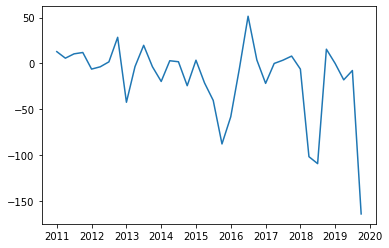

In [32]:
full_test(datetime.date(2011, 1, 1))